# **Кредитный скоринг клиентов банка**

Датасет содержит информацию о 150000 клиентов некоторого банка.

Задача состоит в том, чтобы по различным характеристикам клиентов спрогнозировать целевую переменную - имел клиент просрочку 90 и более дней или нет (и если имел, то банк не будет выдавать кредит этому клиенту, а иначе будет).

## Импорт библиотек

In [119]:
# библиотеки для обработки и анализа структурированных данных
import numpy as np
import pandas as pd

# библиотеки визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# библиотека для работы с несбалансированным набором данных
from imblearn.over_sampling import SMOTENC

# библиотека scikit-learn для машинного обучения
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import pickle

import warnings
warnings.filterwarnings('ignore')

Определим глобальные константы

In [120]:
# параметр рандомизации
RANDOM_STATE = 42

## Загрузка файла

Загружаем данные в датафрейм из CSV-файла

In [121]:
url = 'https://raw.githubusercontent.com/evgpat/edu_stepik_from_idea_to_mvp/main/datasets/credit_scoring.csv'
df = pd.read_csv(url)

## Описание данных

Выведем первые 10 строк таблицы

In [122]:
df.head(10)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines,GroupAge
0,0,0.221813,43.0,0,0.527888,3280.0,7,0,0,2.0,A,c
1,0,0.602794,25.0,0,0.065868,333.0,2,0,0,0.0,A,b
2,1,0.025656,38.0,0,0.475841,3000.0,7,0,0,2.0,A,c
3,0,0.075427,32.0,0,0.085512,7916.0,6,0,0,0.0,A,b
4,0,0.046560,58.0,0,0.241622,2416.0,9,0,0,0.0,A,d
5,1,0.392248,50.0,0,1.595253,4676.0,14,0,0,1.0,B,d
6,0,0.034421,69.0,0,0.042383,2500.0,17,0,0,1.0,A,e
7,0,0.392995,58.0,2,0.436103,5500.0,15,0,0,0.0,A,d
8,1,0.695321,38.0,0,0.618575,7859.0,8,0,0,3.0,A,c
9,0,0.055950,53.0,0,0.052868,2666.0,7,0,0,0.0,A,d


Опишем столбцы (признаки):

**Целевой признак** (таргет) – `SeriousDlqin2yrs`: клиент имел просрочку 90 и более дней

* `RevolvingUtilizationOfUnsecuredLines`: общий баланс по кредитным картам и личным кредитным линиям (за исключением недвижимости и без долгов в рассрочку, таких как автокредиты), разделенный на сумму кредитных лимитов

* `age`: возраст заемщика

* `NumberOfTime30-59DaysPastDueNotWorse`: сколько раз за последние 2 года наблюдалась просрочка 30-59 дней

* `DebtRatio`: ежемесячные расходы (платеж по долгам, алиментам, расходы на проживания) деленные на месячный доход

* `MonthlyIncome`: ежемесячный доход

* `NumberOfOpenCreditLinesAndLoans`: количество открытых кредитов (например, автокредит или ипотека) и кредитных карт

* `NumberOfTimes90DaysLate`: сколько раз наблюдалась просрочка (90 и более дней)

* `NumberOfTime60-89DaysPastDueNotWorse`: сколько раз за последние 2 года заемщик задержал платеж на 60-89 дней

* `NumberOfDependents`: количество иждивенцев на попечении (супруги, дети и др)

* `NumberRealEstateLoansOrLines`: количество кредиов (в том числе под залог жилья)

* `RealEstateLoansOrLines`: закодированное количество кредитов (в том числе под залог жилья) - чем больше код буквы, тем больше кредитов

* `GroupAge`: закодированная возрастная группа - чем больше код, тем больше возраст

Для удобства некоторые столбцы можно переименовать

In [123]:
df.rename(columns={
    'SeriousDlqin2yrs': 'SeriousLate',
    'age': 'Age',
    'RevolvingUtilizationOfUnsecuredLines': 'BalanceRate',
    'NumberOfTime30-59DaysPastDueNotWorse': 'Late30',
    'NumberOfTime60-89DaysPastDueNotWorse': 'Late60',
    'NumberOfTimes90DaysLate': 'Late90',
    'NumberOfOpenCreditLinesAndLoans': 'OpenCredits',
    'NumberOfDependents': 'Dependents',
    'NumberRealEstateLoansOrLines': 'Loans',
    'RealEstateLoansOrLines': 'LoansCode'
}, inplace=True)

df.head(10)

,SeriousLate,BalanceRate,Age,Late30,DebtRatio,MonthlyIncome,OpenCredits,Late90,Late60,Dependents,LoansCode,GroupAge
0,0,0.221813,43.0,0,0.527888,3280.0,7,0,0,2.0,A,c
1,0,0.602794,25.0,0,0.065868,333.0,2,0,0,0.0,A,b
2,1,0.025656,38.0,0,0.475841,3000.0,7,0,0,2.0,A,c
3,0,0.075427,32.0,0,0.085512,7916.0,6,0,0,0.0,A,b
4,0,0.046560,58.0,0,0.241622,2416.0,9,0,0,0.0,A,d
5,1,0.392248,50.0,0,1.595253,4676.0,14,0,0,1.0,B,d
6,0,0.034421,69.0,0,0.042383,2500.0,17,0,0,1.0,A,e
7,0,0.392995,58.0,2,0.436103,5500.0,15,0,0,0.0,A,d
8,1,0.695321,38.0,0,0.618575,7859.0,8,0,0,3.0,A,c
9,0,0.055950,53.0,0,0.052868,2666.0,7,0,0,0.0,A,d


# Исследование данных

Оценим размеры таблицы данных (строки данных, столбцы признаков)

In [124]:
df.shape

(150000, 12)

Выведем информацию о структуре датасета

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   SeriousLate    150000 non-null  int64  
 1   BalanceRate    150000 non-null  float64
 2   Age            135155 non-null  float64
 3   Late30         150000 non-null  int64  
 4   DebtRatio      150000 non-null  float64
 5   MonthlyIncome  120269 non-null  float64
 6   OpenCredits    150000 non-null  int64  
 7   Late90         150000 non-null  int64  
 8   Late60         150000 non-null  int64  
 9   Dependents     146076 non-null  float64
 10  LoansCode      150000 non-null  object 
 11  GroupAge       150000 non-null  object 
dtypes: float64(5), int64(5), object(2)
memory usage: 13.7+ MB


Как видно, почти все признаки - количественные, кроме `LoansCode`, `GroupAge`.

## Разведочный анализ данных (EDA)

Посчитаем распределение клиентов по целевому признаку

In [126]:
target_col = 'SeriousLate'

In [127]:
df[target_col].value_counts()

0    139974
1     10026
Name: SeriousLate, dtype: int64

Целевой признак принимает два значения: 0 или 1, таким образом возникает задача **бинарной классификации**.

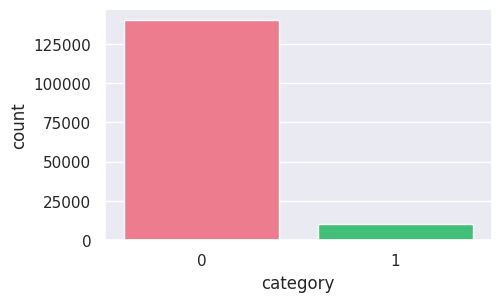

In [128]:
sns.set(rc={'figure.figsize':(5, 3)})
sns.countplot(x=target_col, data=df, palette=['#ff6b81', '#2ed573'])
plt.xlabel("category", size = 12)
plt.ylabel("count", size = 12)
plt.show()

Датасет сильно несбалансирован, это нужно учесть при подготовке данных

### Категориальные признаки

Для категориальных признаков установим специальный категориальный тип.

In [129]:
category_cols = ['LoansCode', 'GroupAge']

In [130]:
df[category_cols] = df[category_cols].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   SeriousLate    150000 non-null  int64   
 1   BalanceRate    150000 non-null  float64 
 2   Age            135155 non-null  float64 
 3   Late30         150000 non-null  int64   
 4   DebtRatio      150000 non-null  float64 
 5   MonthlyIncome  120269 non-null  float64 
 6   OpenCredits    150000 non-null  int64   
 7   Late90         150000 non-null  int64   
 8   Late60         150000 non-null  int64   
 9   Dependents     146076 non-null  float64 
 10  LoansCode      150000 non-null  category
 11  GroupAge       150000 non-null  category
dtypes: category(2), float64(5), int64(5)
memory usage: 11.7 MB


Проверим количество уникальных значений категориальных признаков

In [131]:
df[category_cols].nunique()

LoansCode    5
GroupAge     5
dtype: int64

Выведем частотные диаграммы категориальных признаков

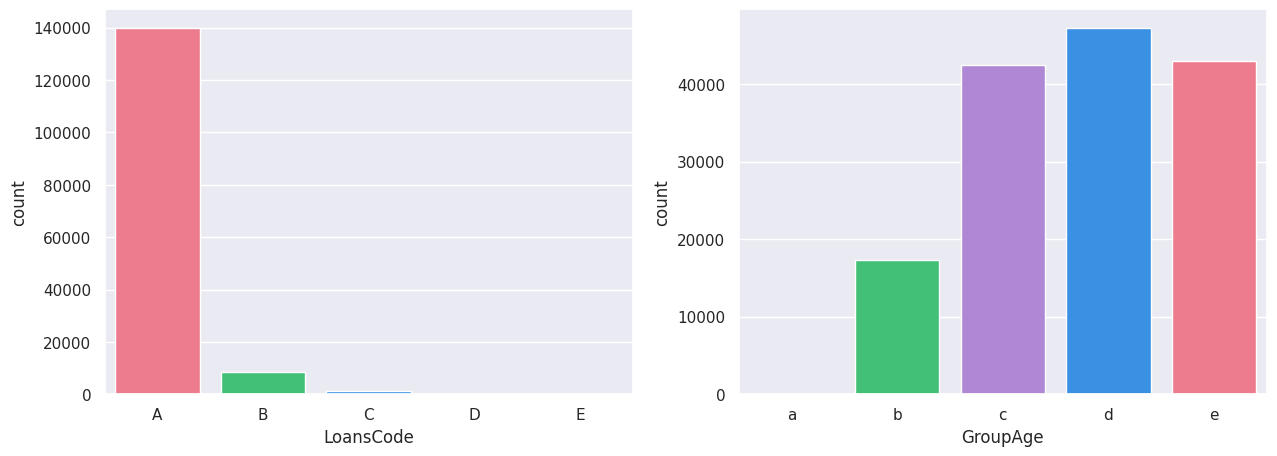

In [132]:
sns.set(rc={'figure.figsize':(15, 5)})

fig, ax = plt.subplots(1,2)
sns.countplot(x='LoansCode', data=df, ax=ax[0], palette=['#ff6b81', '#2ed573', '#1e90ff', '#af7ae2'])
sns.countplot(x='GroupAge', data=df, ax=ax[1], palette=['#ff6b81', '#2ed573', '#af7ae2', '#1e90ff'])
fig.show()

По количеству кредитов клиенты распределены крайне несбалансированно.

Определим границы количества открытых кредитов, соответствующие значениям признака `LoansCode`

In [133]:
for loans_index in df['LoansCode'].astype(str).unique():
    min_loans = int(df[df['LoansCode'] == loans_index]['OpenCredits'].min())
    max_loans = int(df[df['LoansCode'] == loans_index]['OpenCredits'].max())
    print(f'{loans_index}: от {min_loans} до {max_loans}')

A: от 0 до 57
B: от 3 до 49
C: от 6 до 54
E: от 26 до 58
D: от 14 до 40


Определим границы возраста, соответствующие значениям признака `GroupAge`

In [134]:
for age_index in df['GroupAge'].astype(str).unique():
    min_age = int(df[df['GroupAge'] == age_index]['Age'].min())
    max_age = int(df[df['GroupAge'] == age_index]['Age'].max())
    print(f'{age_index}: от {min_age} до {max_age}')

c: от 35 до 49
b: от 21 до 34
d: от 50 до 64
e: от 65 до 109
a: от 0 до 0


В возрастной группе **«a»** присутствует лишь один клиент с возрастом 0, что является ошибкой, эту запись можно исключить.

In [135]:
df[df['GroupAge'] == 'a']

,SeriousLate,BalanceRate,Age,Late30,DebtRatio,MonthlyIncome,OpenCredits,Late90,Late60,Dependents,LoansCode,GroupAge
41655,0,1.0,0.0,1,0.436927,6000.0,6,0,0,2.0,A,a


In [136]:
df.drop(df[df['GroupAge'] == 'a'].index, inplace=True)

Выведем диаграммы распределения клиентов, допустивших просрочку платежа более 90 дней, по категориальным признакам

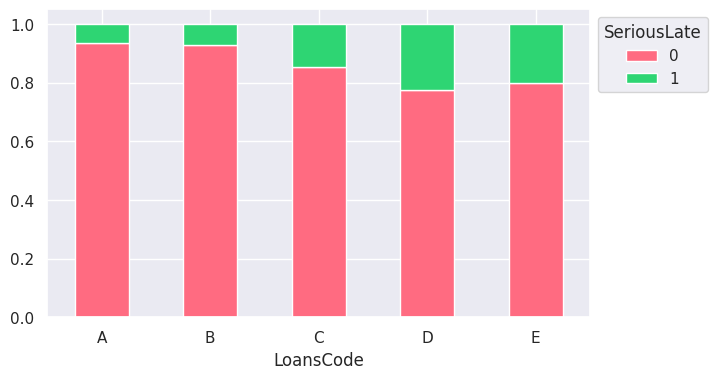

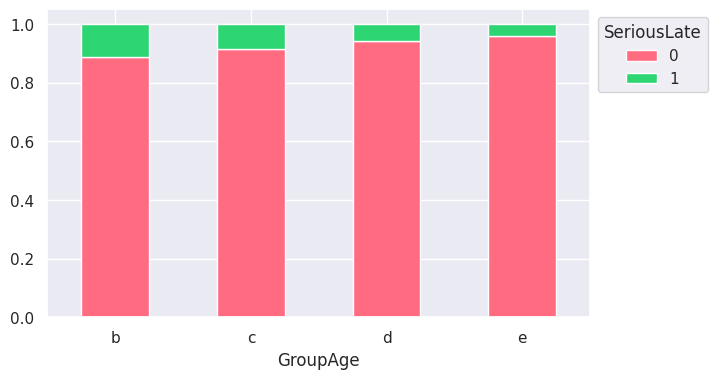

In [137]:
def cat_cross_plot(c):
    tab = pd.crosstab(df[c], df[target_col], normalize='index')
    ax = tab.plot(kind='bar', stacked=True, figsize=(7,4), rot=0, color=['#ff6b81', '#2ed573'])
    plt.legend(title='SeriousLate', bbox_to_anchor=(1,1))
    plt.show()

for c in category_cols:
    cat_cross_plot(c)

Клиенты, имеющие кредиты, с большей вероятностью допустят просрочку платежа.

Чем меньший возраст имеют клиенты, тем более вероятна просрочка.

### Количественные признаки

In [138]:
numeric_cols = df.drop(columns=category_cols + [target_col]).columns

Выведем описательные характеристики

In [139]:
df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
BalanceRate,149999.0,6.048472,249.756203,0.0,0.029867,0.154176,0.559044,50708.0
Age,135154.0,52.294005,14.771947,21.0,41.000000,52.000000,63.000000,109.0
Late30,149999.0,0.421029,4.192795,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,149999.0,353.007426,2037.825113,0.0,0.175074,0.366503,0.868257,329664.0
MonthlyIncome,120268.0,6670.226810,14384.733888,0.0,3400.000000,5400.000000,8249.000000,3008750.0
OpenCredits,149999.0,8.452776,5.145964,0.0,5.000000,8.000000,11.000000,58.0
Late90,149999.0,0.265975,4.169318,0.0,0.000000,0.000000,0.000000,98.0
Late60,149999.0,0.240388,4.155193,0.0,0.000000,0.000000,0.000000,98.0
Dependents,146075.0,0.757214,1.115085,0.0,0.000000,0.000000,1.000000,20.0


Заметны выбросы в признаке `BalanceRate`.

Максимальный возраст 109 лет необычен, но вполне допустим.

Также явно присутствуют выбросы в признаках `Late30`, `Late60`, `Late90`: вряд ли возможно 98 раз (!) за 2 года просрочить платеж на срок от 30 дней.

Признак `DebtRatio` с высокой долей вероятности также содержит аномальные значения.

Судя по большинству значений ежемесячного дохода, можно предположить, что он указан в долларах США, при этом величину дохода более 200 тыс. в месяц можно рассматривать как исключение.

Признаки "Количество открытых кредитов" и "Количество иждивенцев на попечении" в целом не выходит за рамки разумных значений.

Визуализируем распределение значений признаков

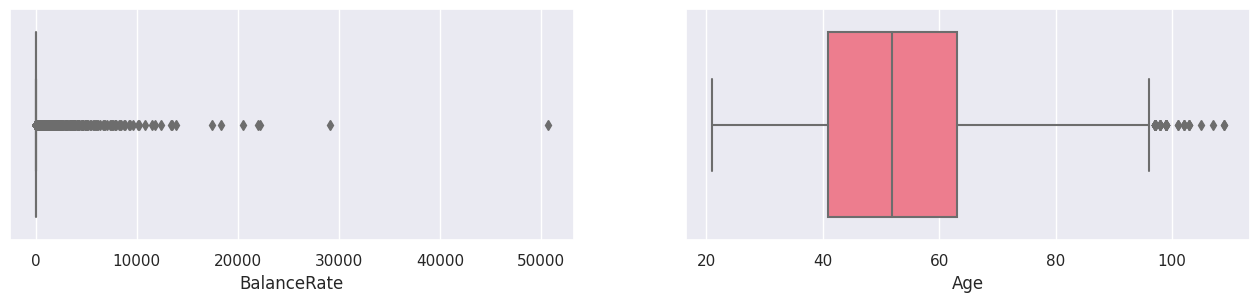

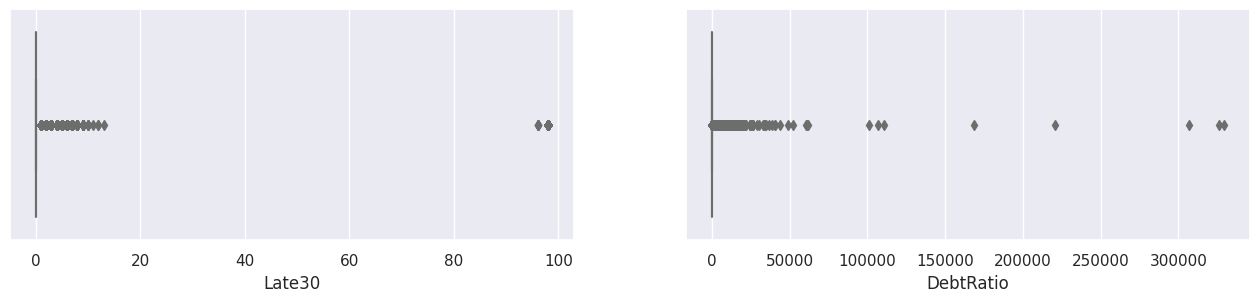

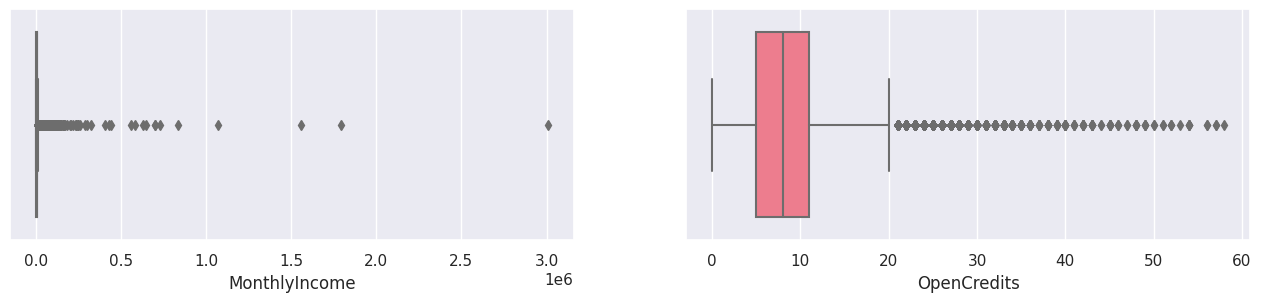

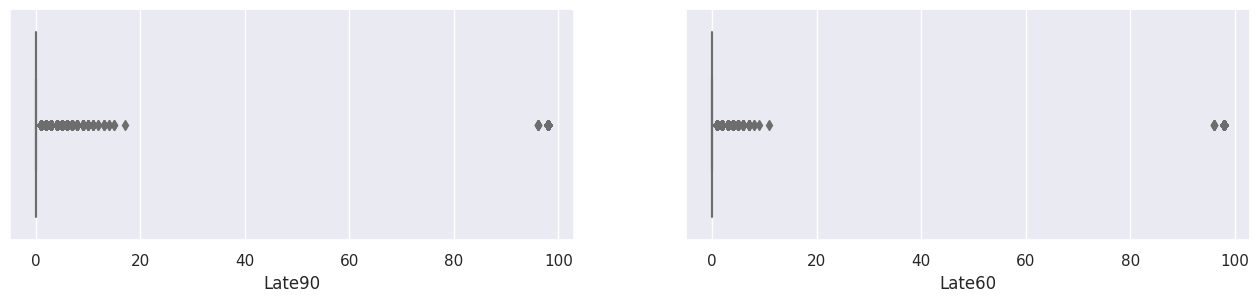

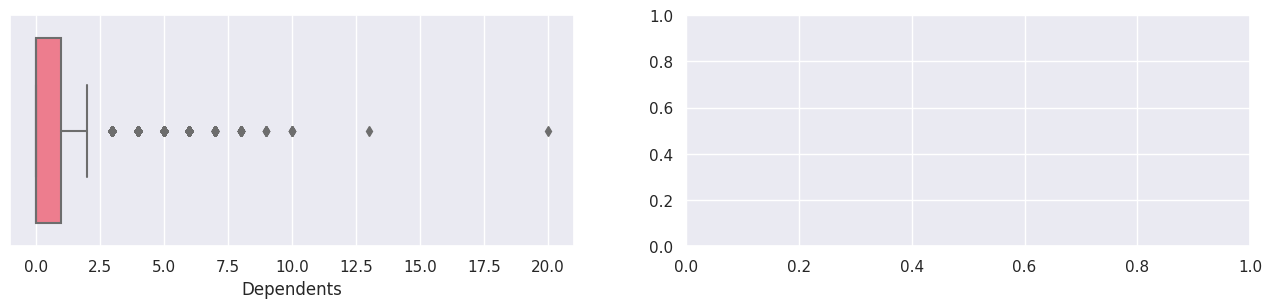

In [140]:
for i in range(-(-len(numeric_cols) // 2)):
    fig, ax = plt.subplots(1, 2, figsize=(16, 3))
    c1 = numeric_cols[i * 2]
    sns.boxplot(x=df[c1], ax=ax[0], palette=['#ff6b81', '#2ed573'])
    if i * 2 + 1 <= len(numeric_cols) - 1:
        c2 = numeric_cols[i * 2 + 1]
        sns.boxplot(x=df[c2], ax=ax[1], palette=['#ff6b81', '#2ed573'])
    plt.show()

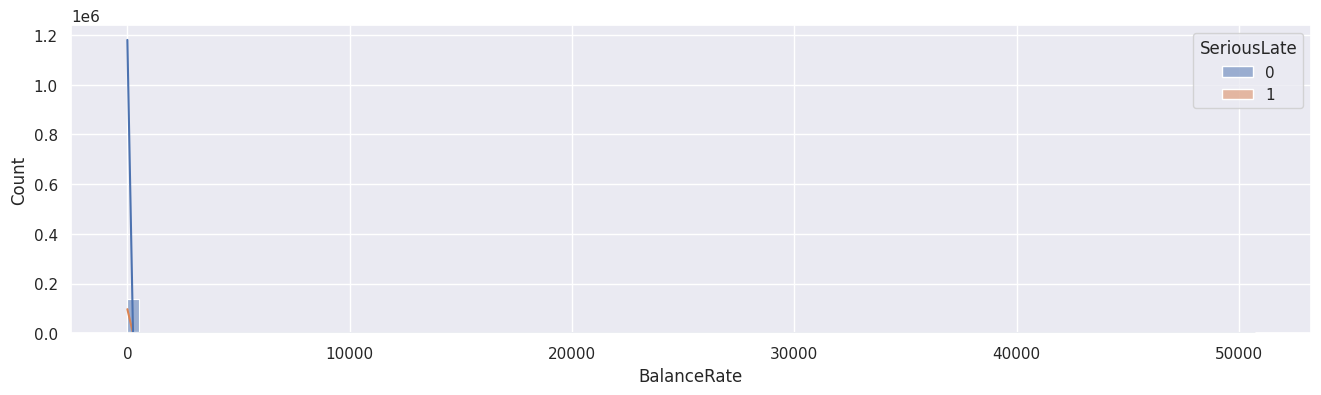

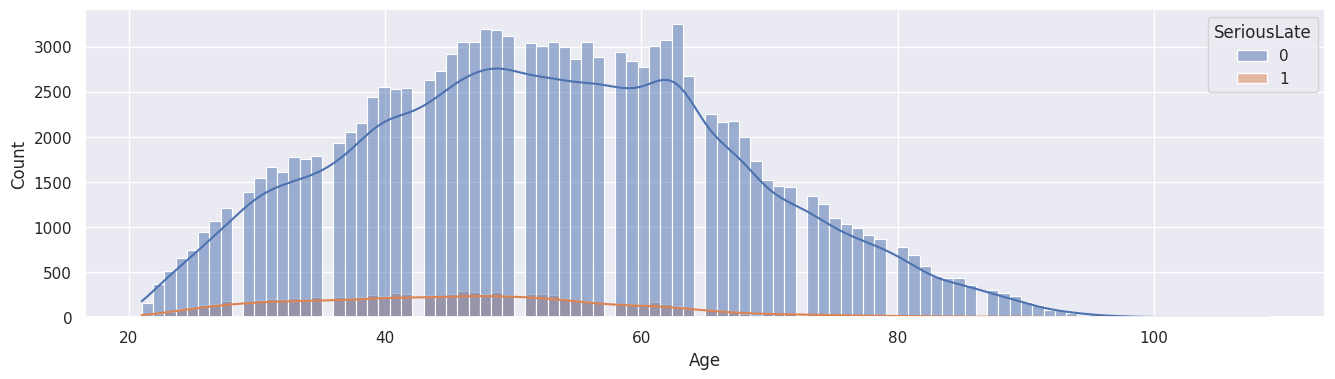

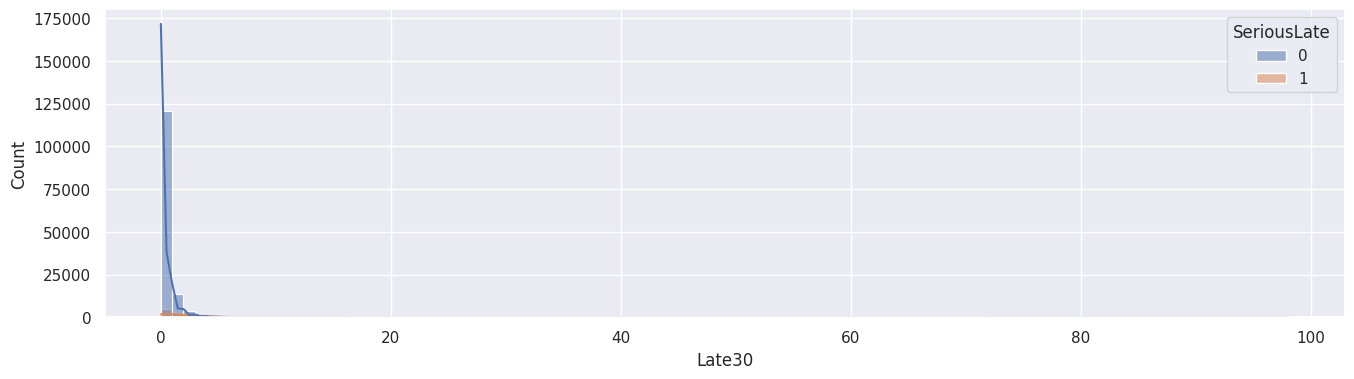

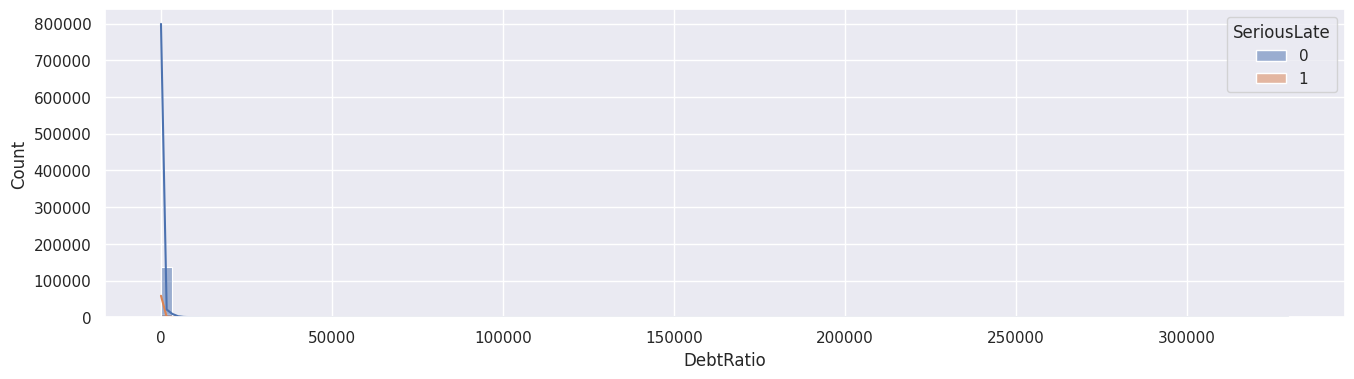

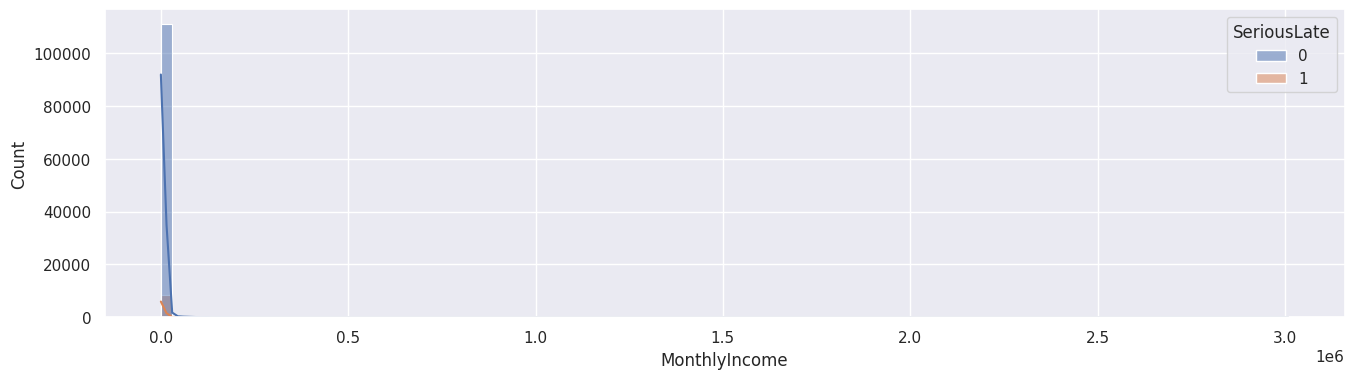

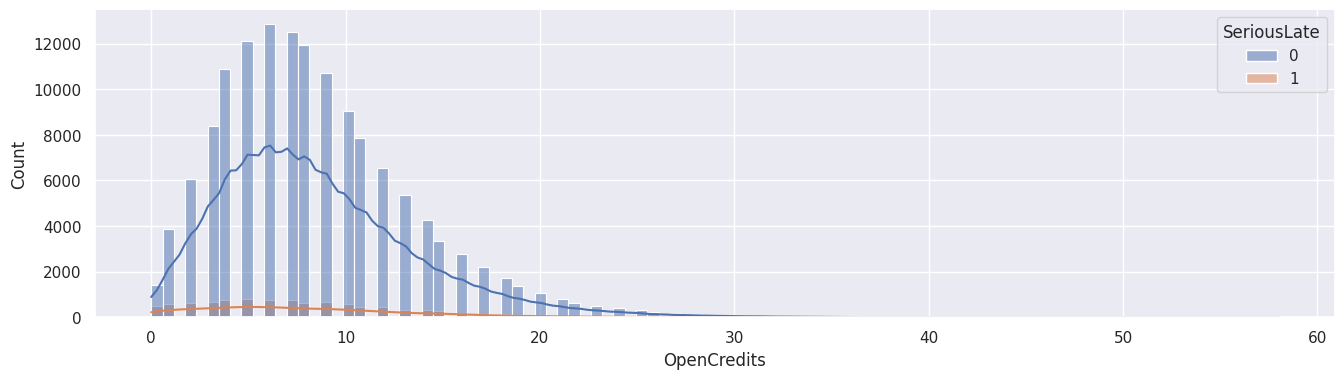

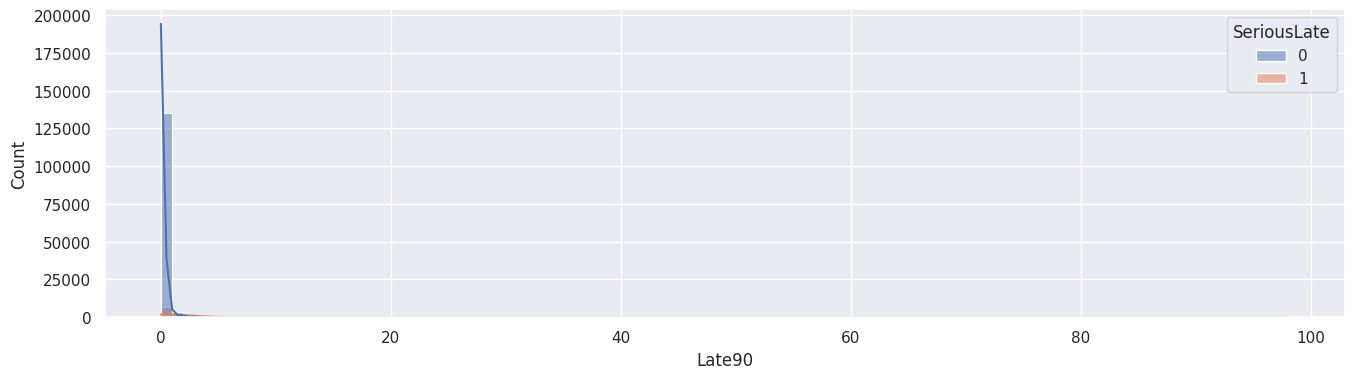

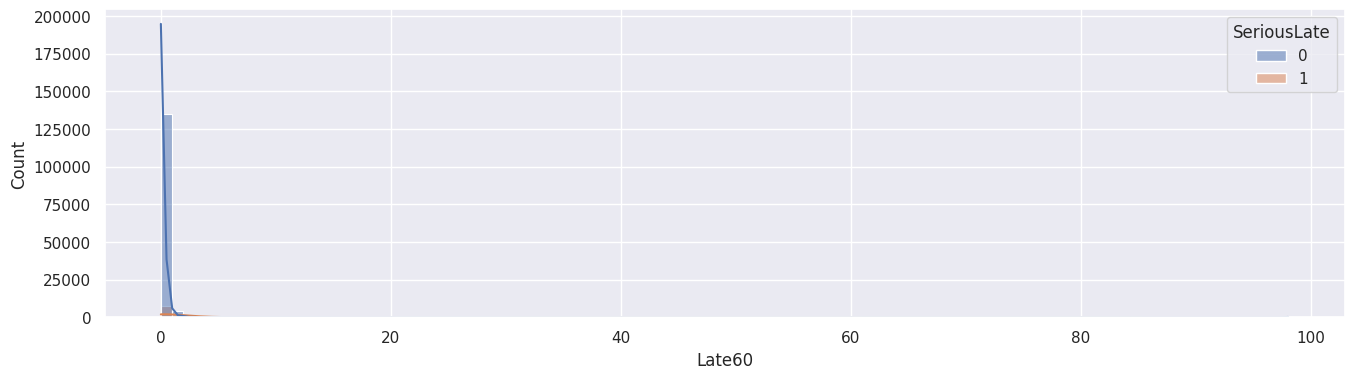

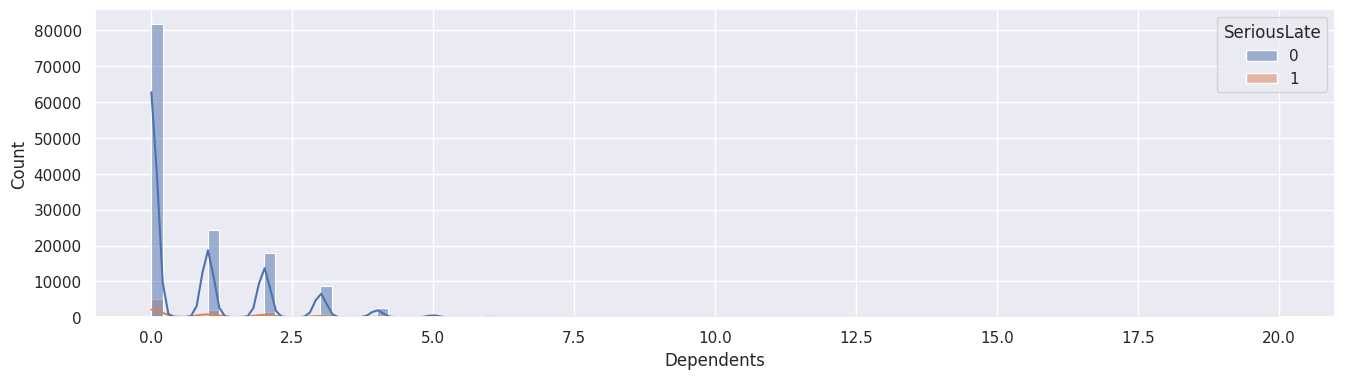

In [141]:
sns.set(rc={'figure.figsize':(16, 4)})

for c in numeric_cols:
    sns.histplot(data=df[[c, target_col]], x=df[c], hue=target_col, kde=True, bins=100);
    plt.show()

На графиках выбросы также заметны.

### Удаление выбросов

In [142]:
limits = {
    'BalanceRate': 2,
    'Late30': 10,
    'Late60': 10,
    'Late90': 10,
    'MonthlyIncome': 30000,
    'OpenCredits': 40,
    'DebtRatio': 3
}

In [143]:
for key in limits:
    print(f'{key}: {df[df[key] > limits[key]].shape[0]}')
    df.drop(df[df[key] > limits[key]].index, inplace=True)

BalanceRate: 371
Late30: 273
Late60: 1
Late90: 15
MonthlyIncome: 785
OpenCredits: 57
DebtRatio: 30147


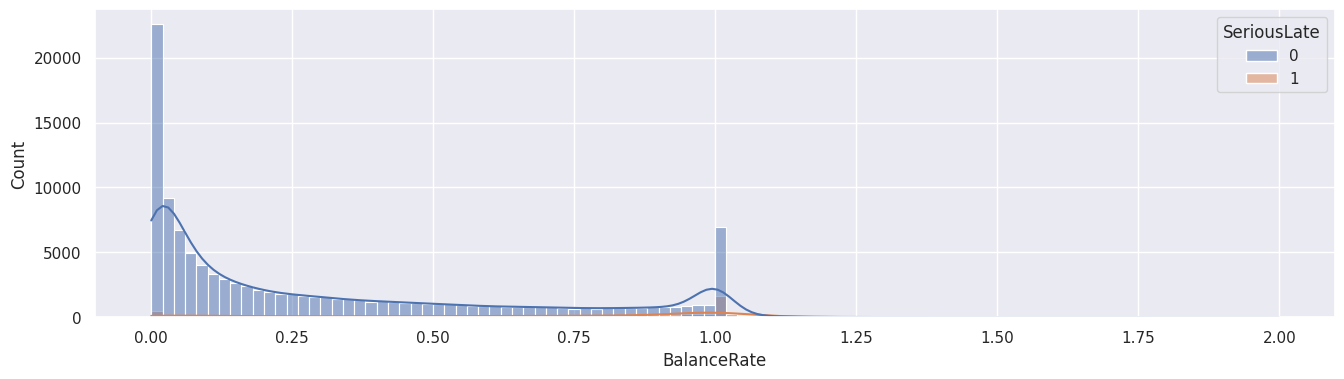

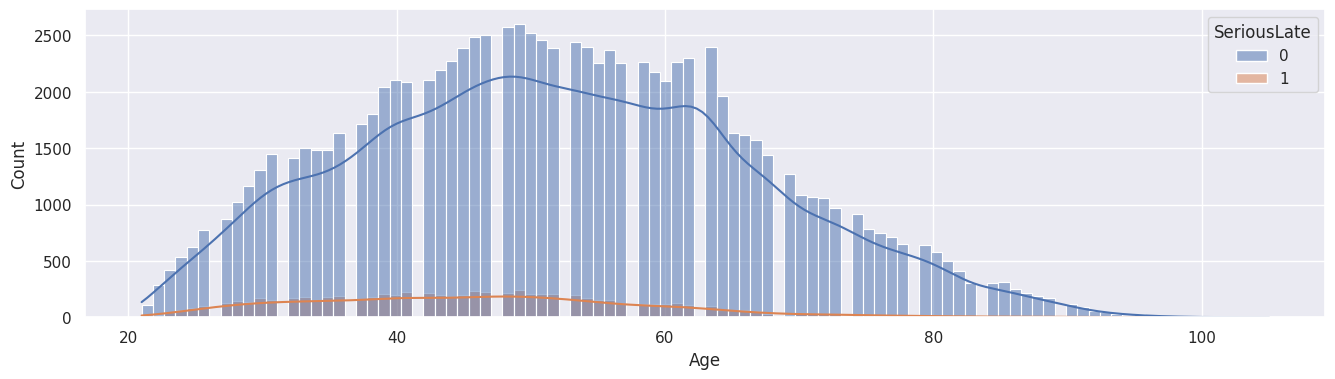

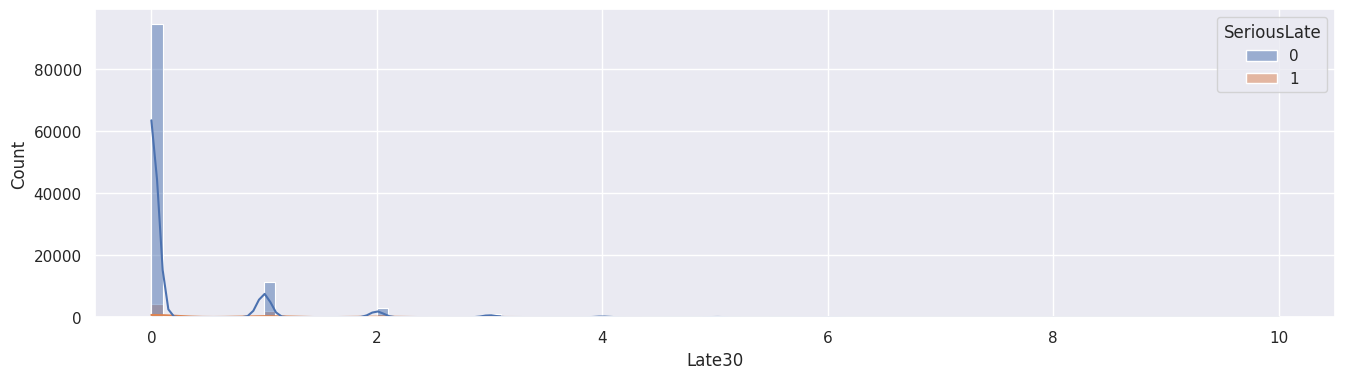

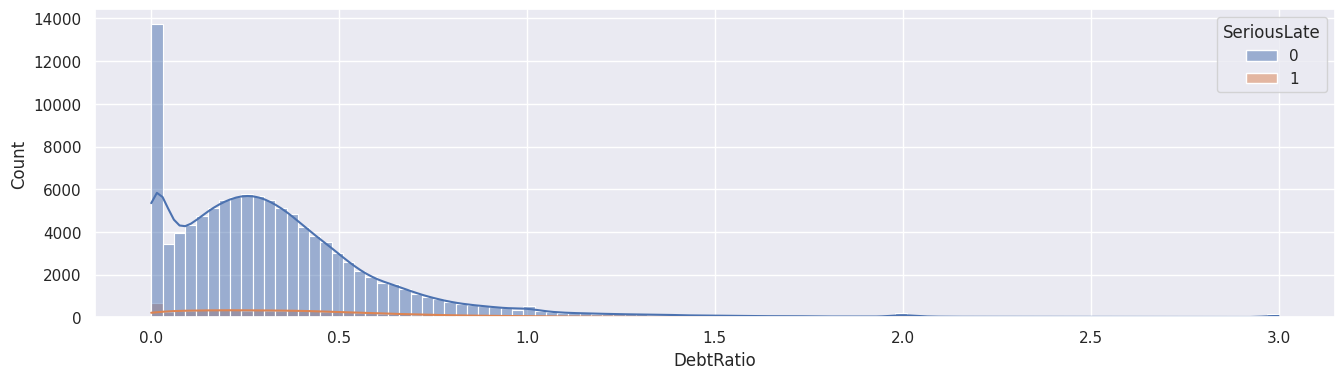

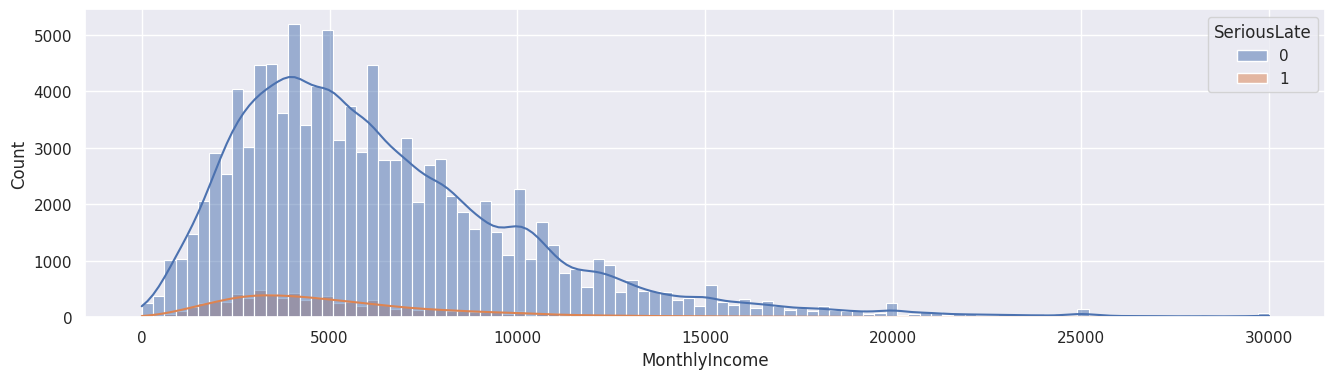

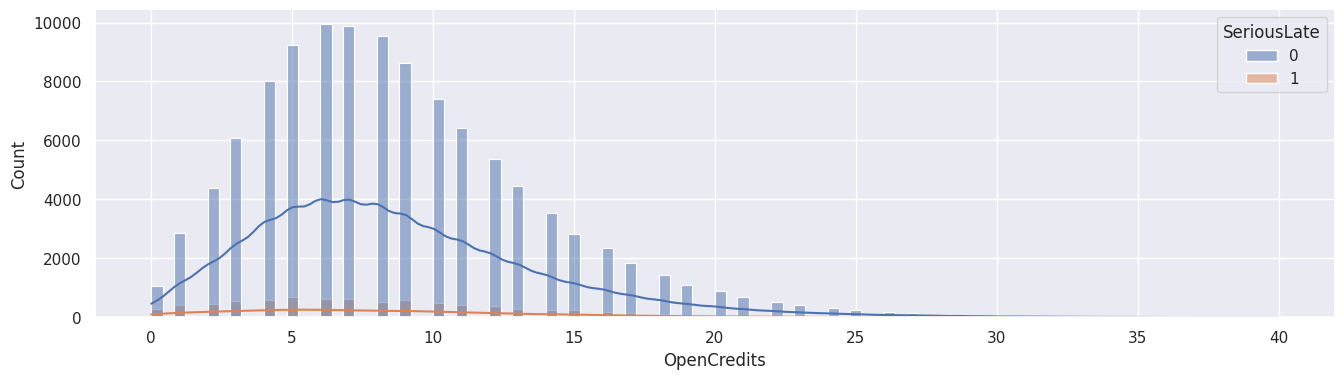

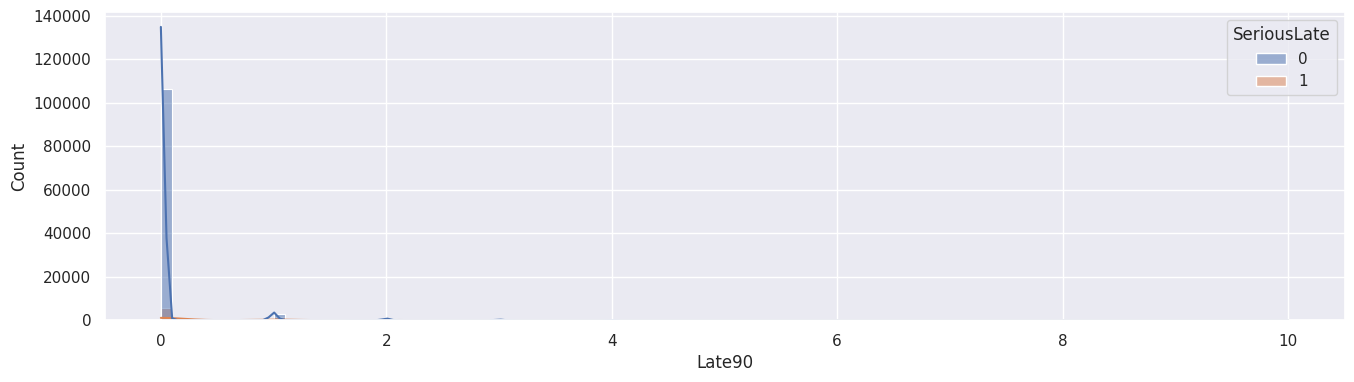

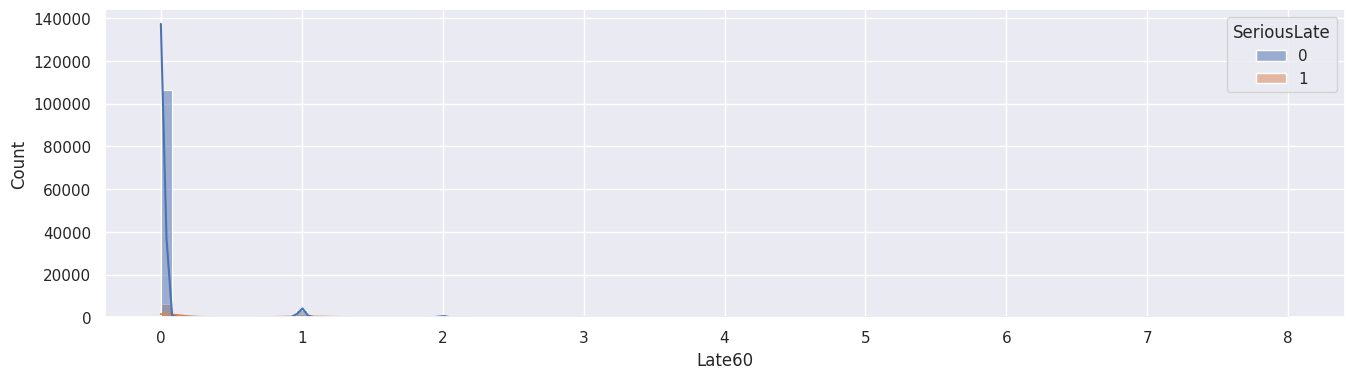

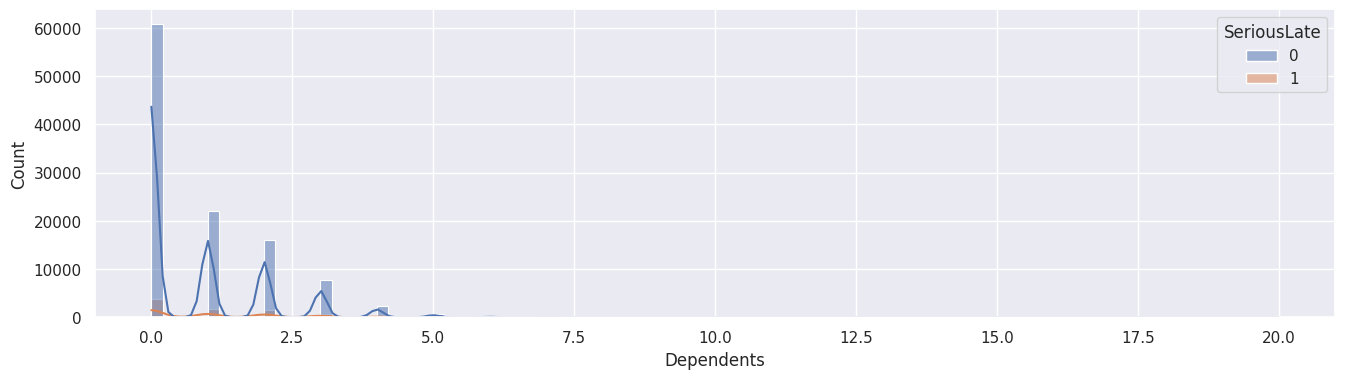

In [144]:
sns.set(rc={'figure.figsize':(16, 4)})

for c in numeric_cols:
    sns.histplot(data=df[[c, target_col]], x=df[c], hue=target_col, kde=True, bins=100);
    plt.show()

Количество записей в датасете после удаления выбросов

In [145]:
df.shape[0]

118350

### Матрица корреляции


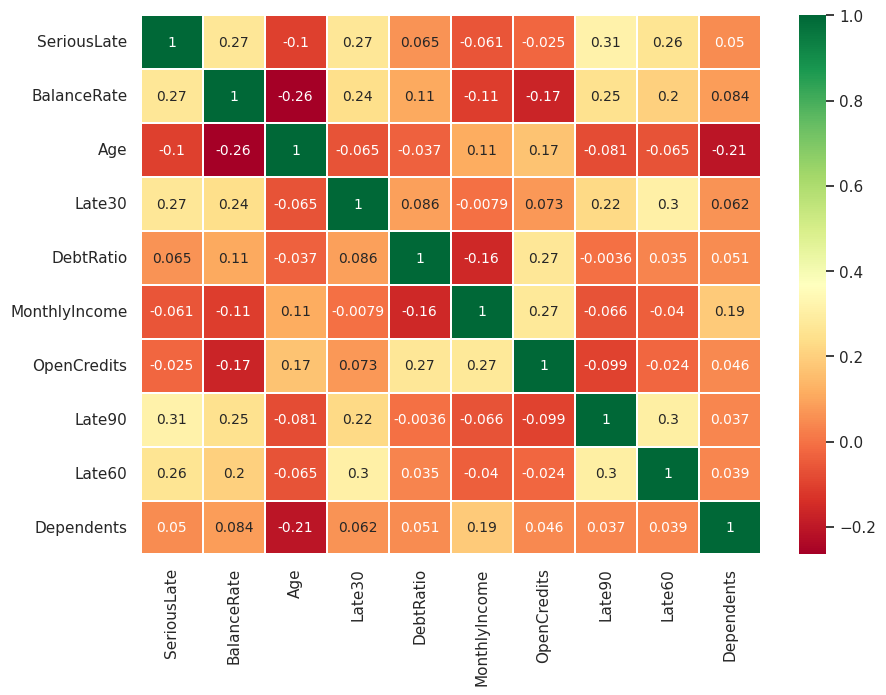

In [146]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2, annot_kws={'size':10});

Можно отметить, что признаки, отражающие количество просрочек за предыдущие 2 года, наряду общим балансом средств, имеют большую корреляцию с целевым признаком.

### Поиск и устранение пропущенных значений

In [147]:
nan_count = pd.DataFrame(df.isnull().sum())
nan_count[1] = round(df.isnull().sum() * 100 / df.shape[0])
nan_count.columns = ['count', '%']
nan_count

,count,%
SeriousLate,0,0.0
BalanceRate,0,0.0
Age,11764,10.0
Late30,0,0.0
DebtRatio,0,0.0
MonthlyIncome,2047,2.0
OpenCredits,0,0.0
Late90,0,0.0
Late60,0,0.0
Dependents,543,0.0


Как видно, признаки `Age`, `MonthlyIncome`, `Dependents` имеют пропущенные значения.

Пропущенные значения возраста можно заполнить усредненными значениями, используя при этом дополнительный признак `GroupAge`, либо просто не использовать этот признак, т.к. он в данном случае будет вносить излишнюю детализацию.

In [148]:
df.drop(columns=['Age'], inplace=True)

Признаки `MonthlyIncome`, `NumberOfDependents` можно заполнить предсказанными данными, но в данной работе для простоты заполним их соответственно средним значением и модой.

In [149]:
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].mean())

In [150]:
df['Dependents'] = df['Dependents'].fillna(float(df['Dependents'].mode()))

Проверим новые данные на наличие пропущенных значений.

In [151]:
df.isnull().sum()

SeriousLate      0
BalanceRate      0
Late30           0
DebtRatio        0
MonthlyIncome    0
OpenCredits      0
Late90           0
Late60           0
Dependents       0
LoansCode        0
GroupAge         0
dtype: int64

Также можно удалить признак `LoansCode`, т.к. он дублирует в обобщенном виде признак `OpenCredits`

In [152]:
df.drop(columns=['LoansCode'], inplace=True)
category_cols.remove('LoansCode')

## Балансировка датасета

Учитывая явный дисбаланс классов, выполним балансировку датасета дополнением данных из миноритарной категории.

Для этого используем класс **SMOTENC** из библиотеки imbalanced-learn, который работает с числовыми и категориальными признаками.


In [153]:
over_sampler = SMOTENC(random_state=42, categorical_features=[9]) # categorical_features - порядковые номера категориальных признаков
df_sampled, _ = over_sampler.fit_resample(df, df[target_col])

Теперь классы сбалансированы

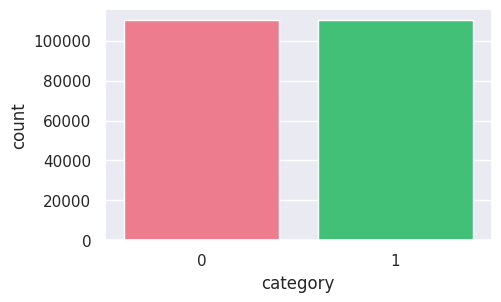

In [154]:
sns.set(rc={'figure.figsize':(5, 3)})
sns.countplot(x=target_col, data=df_sampled, palette=['#ff6b81', '#2ed573'])
plt.xlabel("category", size = 12)
plt.ylabel("count", size = 12)
plt.show()

# Подготовка модели машинного обучения

Сформируем данные для обучения моделей. Выделим целевой признак.

In [155]:
X = df_sampled.drop(target_col, axis=1)
Y = df_sampled[target_col]

## Кодирование категориальных признаков

Значения категориальных признаков необходимо закодировать

In [156]:
X = pd.get_dummies(X, columns=category_cols, drop_first=True)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220464 entries, 0 to 220463
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   BalanceRate    220464 non-null  float64
 1   Late30         220464 non-null  int64  
 2   DebtRatio      220464 non-null  float64
 3   MonthlyIncome  220464 non-null  float64
 4   OpenCredits    220464 non-null  int64  
 5   Late90         220464 non-null  int64  
 6   Late60         220464 non-null  int64  
 7   Dependents     220464 non-null  float64
 8   GroupAge_b     220464 non-null  uint8  
 9   GroupAge_c     220464 non-null  uint8  
 10  GroupAge_d     220464 non-null  uint8  
 11  GroupAge_e     220464 non-null  uint8  
dtypes: float64(4), int64(4), uint8(4)
memory usage: 14.3 MB


## Разделение на обучающую и тестовую выборки

Разделим данные на обучающую и тестовую выборки, выполнив при этом стратификацию данных, что особенно важно при несбалансированных данных.

In [157]:
# разделим данные на тренировочную и тестовую выборки в пропорции 80 / 20
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state=RANDOM_STATE, stratify=Y)

## Масштабирование данных

In [158]:
# используем стандартный трансформер
scaler = StandardScaler()

# масштабируем обучающую выборку
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# масштабируем тестовую выборку, используя статистики обучающей выборки
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

# Обучение моделей

Для подбора лучшего варианта обучения модели сформируем различные конфигурации классификаторов. Будем использовать следующие методы:
* Наивный байесовский классификатор
* Логистическая регрессия
* Стохастический градиентный спуск
* Метод случайного леса

In [159]:
# наивный байесовский классификатор
def get_pipeline_GNB():
    pipeline = Pipeline([
        ('clf', GaussianNB())
    ])
    return pipeline

# логистическая регрессия
def get_pipeline_LR():
    pipeline = Pipeline([
        ('clf', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
    ])
    return pipeline

# стохастический градиентный спуск
def get_pipeline_SGD():
    pipeline = Pipeline([
        ('clf', SGDClassifier(random_state=RANDOM_STATE))
    ])
    return pipeline

# случайный лес
def get_pipeline_RFC():
    pipeline = Pipeline([
        ('clf', RandomForestClassifier(n_estimators=1000, random_state=RANDOM_STATE))
    ])
    return pipeline

Зададим функцию обучения модели:
* выбираем проверяемую модель и набор гиперпараметров
* выполняем перебор гиперпараметров классификатора для определения наилучших
* обучаем модель на тренировочной выборке
* тестируем модель на тестовой выборке
* возвращаем оценку и набор гиперпараметров лучшей конфигурации

Для простоты будем использовать метрику **F1-score**, но для реального кредитного скоринга целесообразно использовать другие метрики.

In [160]:
def train_model(X_train, y_train, X_test, y_test, get_pipeline, parameters):
    # выбираем тестируемую конфигурацию и набор параметров
    pipeline = get_pipeline()

    # выполняем перебор для определения наилучших параметров
    # с использованием метрики recall
    model = GridSearchCV(pipeline, parameters, scoring='f1')
    model.fit(X_train, y_train)

    # получаем набор параметров лучшей конфигурации
    best_parameters = {}
    best_estimator_parameters = model.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        best_parameters[param_name] = best_estimator_parameters[param_name]
    model_results = model.cv_results_

    # выбираем лучшую модель
    predictor = model.best_estimator_

    # обучаем модель на тренировочной выборке
    best_model = predictor.fit(X_train, y_train)

    # тестируем модель
    prediction_train = predictor.predict(X_train)
    prediction_test = predictor.predict(X_test)

    # рассчитываем метрики оценки модели
    model_train_metric = [
        metrics.accuracy_score(prediction_train, y_train),
        metrics.precision_score(prediction_train, y_train),
        metrics.recall_score(prediction_train, y_train),
        metrics.roc_auc_score(prediction_train, y_train),
        metrics.f1_score(prediction_train, y_train)
    ]
    model_test_metric = [
        metrics.accuracy_score(prediction_test, y_test),
        metrics.precision_score(prediction_test, y_test),
        metrics.recall_score(prediction_test, y_test),
        metrics.roc_auc_score(prediction_test, y_test),
        metrics.f1_score(prediction_test, y_test)
    ]

    # возвращаем параметры модели и метрики
    return model_results, best_parameters, model_train_metric, model_test_metric

# Проведение экспериментов и оценка моделей

Зададим функцию проведения эксперимента и вывода результатов.

In [161]:
def do_experiment(ex):
    model_results, best_parameters, model_train_metric, model_test_metric = train_model(X_train_scaled, y_train, X_test_scaled, y_test, ex[1], ex[2])
    print("Модель:", ex[0])
    print(f"              train   test")
    print(f"   Accuracy:  {model_train_metric[0]:.4f}    {model_test_metric[0]:.4f}")
    print(f"  Precision:  {model_train_metric[1]:.4f}    {model_test_metric[1]:.4f}")
    print(f"     Recall:  {model_train_metric[2]:.4f}    {model_test_metric[2]:.4f}")
    print(f"         F1:  {model_train_metric[4]:.4f}    {model_test_metric[4]:.4f}")
    print("Лучший набор гиперпараметров:")
    for param_name in sorted(best_parameters.keys()):
        print(f"\t{param_name.replace('clf__', '')}: {best_parameters[param_name]}")
    print("-" * 30)
    print("")
    return model_test_metric[4]

Для каждой конфигурации указываем набор гиперпараметров и перечень значений, используемых для подбора наилучшего сочетания.

Проведем эксперименты для всех заданных конфигураций.

In [162]:
# список экспериментов
experiments = [
    ['Naive Bayes', get_pipeline_GNB, {

      }],
    ['Log Reg', get_pipeline_LR, {
        'clf__C': [0.01, 0.05, 0.1, 1]
      }],
    ['SGD', get_pipeline_SGD, {
        'clf__n_iter_no_change': (1, 3, 5)
      }],
    ['RFC', get_pipeline_RFC, {
        'clf__max_depth': (2, 3, 4)
      }]
]

model_estim_x = []
model_estim_val = []

for ex in experiments:
  model_estim_x.append(ex[0])
  model_estim_val.append(do_experiment(ex))

Модель: Naive Bayes
              train   test
   Accuracy:  0.6945    0.6983
  Precision:  0.5217    0.5269
     Recall:  0.7973    0.8016
         F1:  0.6307    0.6359
Лучший набор гиперпараметров:
------------------------------

Модель: Log Reg
              train   test
   Accuracy:  0.7417    0.7421
  Precision:  0.7331    0.7365
     Recall:  0.7459    0.7449
         F1:  0.7395    0.7407
Лучший набор гиперпараметров:
	C: 1
------------------------------

Модель: SGD
              train   test
   Accuracy:  0.7403    0.7405
  Precision:  0.7385    0.7418
     Recall:  0.7412    0.7398
         F1:  0.7398    0.7408
Лучший набор гиперпараметров:
	n_iter_no_change: 1
------------------------------

Модель: RFC
              train   test
   Accuracy:  0.7654    0.7674
  Precision:  0.8311    0.8357
     Recall:  0.7345    0.7353
         F1:  0.7799    0.7823
Лучший набор гиперпараметров:
	max_depth: 4
------------------------------



Выведем диаграмму для сравнения метрик в каждой из конфигураций

<BarContainer object of 4 artists>

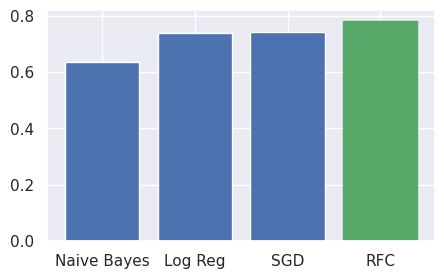

In [163]:
max_index = model_estim_val.index(max(model_estim_val))
metrics_bar = plt.bar(model_estim_x, model_estim_val)
metrics_bar[max_index].set_color('g')
metrics_bar

Таким образом, можно выбрать модель на основе случайного леса.

Оценим веса признаков, которые использует модель на основе логистической регрессии

In [164]:
clf = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, C=0.05)
clf.fit(X_train, y_train)

LogisticRegression(C=0.05, max_iter=1000, random_state=42)

In [165]:
c = pd.DataFrame(clf.coef_, columns=X_train.columns).T.sort_values(by=[0], ascending=False)
c

,0
BalanceRate,2.360659
Late90,0.800193
Late30,0.420548
DebtRatio,0.407482
Late60,0.371289
Dependents,0.036063
OpenCredits,0.021607
MonthlyIncome,-0.000022
GroupAge_b,-0.020100
GroupAge_c,-0.020880


Как и ожидалось, наибольшее влияние оказывают признаки, отражающие общий баланс средств и количество просрочек за предыдущие 2 года, отношение ежемесячных расходов к доходам, а также возрастная группа.

Выведем матрицу соответствий для лучшей модели на основе случайного леса

In [166]:
def cm_plot(y_test, y_pred, labels=None):
  sns.set(font_scale=1.2)
  cm = confusion_matrix(y_test, y_pred, labels=labels)
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots(figsize=(4, 4))
  sns.heatmap(cmn, fmt='.2f', cmap='Blues', annot=True, cbar=False, xticklabels=labels, yticklabels=labels)
  plt.xlabel("Predicted label")
  plt.ylabel("True label")
  plt.show()
  return cm

In [167]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=4, random_state=RANDOM_STATE)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

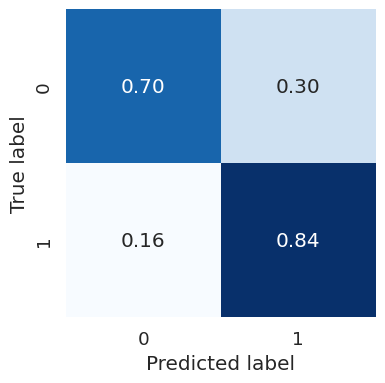

In [168]:
cm = cm_plot(y_test, y_pred, labels=[0, 1])

Корректировкой порога можно увеличивать охват/точность

In [169]:
classes = y_proba > 0.6

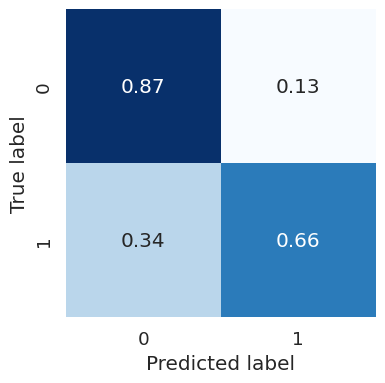

In [170]:
cm = cm_plot(y_test, classes, labels=[0, 1])

In [171]:
classes = y_proba > 0.4

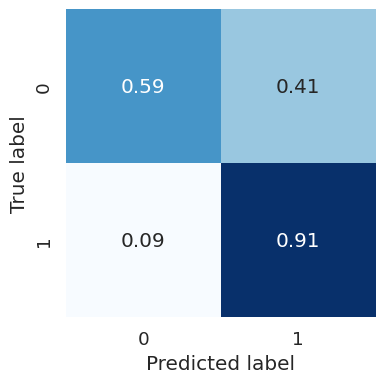

In [172]:
cm = cm_plot(y_test, classes, labels=[0, 1])

### Сохранение весов обученной модели и параметров масштабирования

In [174]:
model_filename = 'clf.sav'
pickle.dump(clf, open(model_filename, 'wb'))

scaler_filename = 'scaler.sav'
pickle.dump(scaler, open(scaler_filename, 'wb'))

# Выводы

Для повышения эффективности выдачи кредитов стоит учитывать следующие критерии:

* Чем больше открытых кредитов есть у клиентов, тем с большей вероятностью они могут допустить просрочку платежа

* Чем меньший возраст имеют клиенты, тем просрочка более вероятна

* Важно учиывать общий баланс средств, а также отношение ежемесячных расходов к доходам

Метрика, используемая в процессе обучения, позволяет сбалансировать количество выявленных потенциальных просрочек платежей, при этом уменьшая ложные срабатывания.